# final algorithm design

### In this notebook, 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath("../"))  # or "." or ".." depending on your structure

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from models.model_utils import mask_observations, params
from models.linear_model import LinearModel_Estimator
from calibrator_module.BCUC_calibrator_finalVersion import BCUC_Calibrator
from models.model_utils import params
from calibrator_module.NLL_gradient_descent_calibrator import NLLGD_Calibrator


In [39]:

!python ../observation_generation.py --dir_path "../observations" --format npz --n_steps 10000

4732.80s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Creating linear system...
[[0.3]]

Generating observations for random_zeros_and_actions actions...
Generated 10001 observations
Observation shape: (1,)
Data saved as ../observations/observations_random_zeros_and_actions_for_Q0.3_steps_10000.npz
Model parameters saved as ../observations/observations_random_zeros_and_actions_for_Q0.3_steps_10000_params.json
Observation mean: [4.85750018]
Observation std: [1.76903086]
Observation generation complete!

Recommended workflow:
1. Use .npz format for numerical analysis in Python
2. Use .csv format for analysis in Excel or pandas
3. Use .json format for human-readable debugging
4. Use .mat format for MATLAB interoperability


In [ ]:
# --- load data ---
from models.model_utils import params
persons = [0.01, 0.3, 0.7, 1.5]
initial_model = LinearModel_Estimator(**params)   # e.g., Q_initial = mean(persons)
print(f"Initial Q matrix: {initial_model.Q}")
calibrated_models = []
metrics = []
# --- 1) B-CUC: quantile-coupled (q_t -> anchored Q) ---
cal_qc = BCUC_Calibrator(
    initial_model=initial_model,
    alpha=0.32,          # μ±σ target; keeps Q identification unbiased if Gaussian
)
for person in persons:
    path_to_load = f"../observations/observations_random_zeros_and_actions_for_Q{person}_steps_10000.npz"
    data = np.load(path_to_load, allow_pickle=True)
    masked_observations = mask_observations(data['observations'])
    actions = data['actions']

    # --- build model ---
    to_print = f"Target (true) Q*: {person}"
    print(to_print)

    model_qc = cal_qc.calibrate_model(masked_observations, actions)
    calibrated_models.append(model_qc)
    # --- evaluate metrics ---
    metrics_qc = cal_qc.get_metrics(person)
    metrics.append(metrics_qc)
    # --- print results ---
    print("\n[BCUC quantile_coupled]")
    print("metrics:", metrics_qc)
    print("final Q:", model_qc.Q)
    print()

Initial Q matrix: [[0.6275]]
Target (true) Q*: 0.01

[BCUC quantile_coupled]
metrics: {'E_bar': 0.28554979850316636, 'coverage': 0.7144502014968337, 'mean_interval_width': 0.3351726108909286, 'avg_nll': -0.9813455934013139, 'final_difference': 0.014743392780994844, 'relative_error': 1.4743392780994844}
final Q: [[0.02474339]]
Target (true) Q*: 0.3

[BCUC quantile_coupled]
metrics: {'E_bar': 0.31174438687392053, 'coverage': 0.6882556131260795, 'mean_interval_width': 0.47167508362214994, 'avg_nll': -0.15344284187137178, 'final_difference': 0.007618725715941133, 'relative_error': 0.025395752386470443}
final Q: [[0.30761873]]
Target (true) Q*: 0.7

[BCUC quantile_coupled]
metrics: {'E_bar': 0.31246401842256766, 'coverage': 0.6875359815774323, 'mean_interval_width': 0.621952171730318, 'avg_nll': 0.21890311741513538, 'final_difference': 0.009533650727579834, 'relative_error': 0.013619501039399764}
final Q: [[0.70953365]]
Target (true) Q*: 1.5

[BCUC quantile_coupled]
metrics: {'E_bar': 0.312

In [7]:
# --- plot results ---
metrics_qc = cal_qc.get_metrics()
print("\n[BCUC quantile_coupled]")
print("metrics:", metrics_qc)
print("final Q:", model_qc.Q)

# metrics_qf = cal_qf.get_metrics()
# print("\n[BCUC quantile_free]")
# print("metrics:", metrics_qf)
# print("final Q:", model_qf.Q)

# metrics_nll = cal_nll.get_metrics()
# print("\n[NLLGD baseline]")
# print("metrics:", metrics_nll)
# print("final Q:", model_nll.Q)


[BCUC quantile_coupled]
metrics: {'E_bar': 0.31879677605066203, 'coverage': 0.681203223949338, 'mean_interval_width': 0.6806743256752487, 'avg_nll': 0.2276099170657401}
final Q: [[0.8915074]]


In [ ]:
data['observations'].size

In [32]:
Q_vals_qc = cal_qc.Q_history
# Q_vals_qf = cal_qf.Q_history
# Q_vals_nll = cal_nll.Q_history

q_vals_qc = cal_qc.q_history
# q_vals_qf = cal_qf.q_history #should be 1 always - just for sanity check

interval_widths_qc = cal_qc.interval_widths
# interval_widths_qf = cal_qf.interval_widths
# interval_widths_nll = cal_nll.interval_widths

E_qc = cal_qc.conformal_p_control.E
# E_qf = cal_qf.conformal_p_control.E
# E_null = [1 - h for h in cal_nll.coverage_hits]

interval_widths_with_correction_qc = [val*q for val, q in zip(interval_widths_qc, q_vals_qc)]
sigma_qc = [std/2 for std in interval_widths_with_correction_qc] #this is the vlaues of the std but calculated right after the prediction 
#step (without the update step in case of observation available)
# #it is necessary to follow this value to evaluate our calibration mechanism (we can check the interval width and cover precision)
# sigma_qf = [std/2 for std in interval_widths_qf]
# sigma_null = [std/2 for std in interval_widths_nll]

meu_qc = [dictionary['mean'].flatten() for dictionary in model_qc.dist_estimates]
std_qc = [np.sqrt(dictionary['var'].flatten()) for dictionary in model_qc.dist_estimates]
meu_qc = np.array(meu_qc[1:]).squeeze()   
std_qc = np.array(std_qc[1:]).squeeze()

# meu_qf = [dictionary['mean'].flatten() for dictionary in model_qf.dist_estimates]
# std_qf = [np.sqrt(dictionary['var'].flatten()) for dictionary in model_qf.dist_estimates]
# meu_qf = np.array(meu_qf[1:]).squeeze()   
# std_qf = np.array(std_qf[1:]).squeeze()

# meu_nll = [dictionary['mean'].flatten() for dictionary in model_nll.dist_estimates]
# std_nll = [np.sqrt(dictionary['var'].flatten()) for dictionary in model_nll.dist_estimates]
# meu_nll = np.array(meu_nll[1:]).squeeze()   
# std_nll = np.array(std_nll[1:]).squeeze()

In [106]:
dir_name = "plots/second_person"
os.makedirs(dir_name, exist_ok=True)

## Plots

In [41]:
from utils.utils import plot_one, plot_two

NameError: name 'dir_name' is not defined

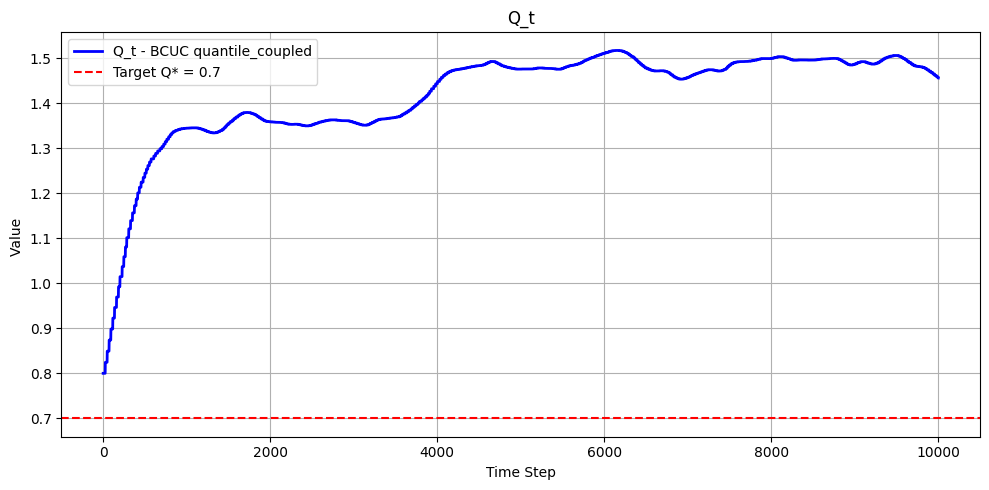

In [33]:
# plot_one(x = None, y=Q_vals, title="Process Noise over Timesteps", x_label="Time Step", y_label="Q_t", label="Q_t", dir_name=dir_name, fig_name="Q_t.png")
plt.figure(figsize=(10, 5))
plt.plot(Q_vals_qc, label="Q_t - BCUC quantile_coupled", color='blue', linewidth=2)
plt.axhline(y=0.7, color='red', linestyle='--', label="Target Q* = 0.7")
plt.xlabel("Time Step")
plt.ylabel("Value ")
plt.title("Q_t")

plt.legend()
plt.grid(True)
plt.tight_layout()
fig_name = "Q_t_over_time.png"
full_path = os.path.join(dir_name, fig_name)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
Q_mean_last_k_qc = np.mean(Q_vals_qc[:])
print(Q_mean_last_k_qc)


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(interval_widths_with_correction_qc, label="Prediction Interval Width - BCUC quantile_coupled", color='blue', linewidth=2)
plt.xlabel("Time Step")
plt.ylabel("Width")
plt.title("Prediction Interval Width Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
fig_name = "plot_interval_width.png"
full_path = os.path.join(dir_name, fig_name)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(q_vals_qc)), q_vals_qc,  label="q_t")
# plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("q_t")
plt.legend()
plt.grid(True)
plt.tight_layout()
fig_name = "q_t.png"
full_path = os.path.join(dir_name, fig_name)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
time_steps = range(len(E_qc[600:]))  # or your actual time step data
plt.scatter(time_steps, E_qc[600:], label="coverage error")
# plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Binary Coverage Errors Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
fig_name = "E_t.png"
full_path = os.path.join(dir_name, fig_name)
plt.savefig(full_path, dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
time_steps = range(len(E))  # or your actual time step data
plt.scatter(E, Q_vals, label="coverage error")
# plt.yscale("log")
plt.xlabel("E_bar")
plt.ylabel("Q_t")
plt.title("Binary Coverage Errors Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
np.mean(E)

In [ ]:
sigma = np.array(sigma).flatten()
sigma

In [ ]:
plt.figure(figsize=(10, 5))
ts = np.arange(len(meu)) 
plt.plot(ts, meu, label=" meu")
# plt.fill_between(ts, meu- std, meu + std, alpha=0.2, label="Confidence Interval")
# plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Mean and Standard Deviation Over Time vs Observations")
plt.grid(True)
plt.tight_layout()
plt.savefig("calibrated_distribution_over_time_vs_observation.png", dpi=300)
plt.fill_between(ts, meu - sigma, meu + sigma, alpha=0.2, label="Confidence Interval")
ts_new = np.arange(np.size(masked_observations))
# mask = ~np.isnan(masked_observations)
# ts_valid = ts_new[mask.flatten()]
# obs_valid = masked_observations[mask.flatten()]
# plt.scatter(ts_valid, obs_valid, color='red', label='Observations')
obs = data['observations']
plt.scatter(ts_new, obs, color='red', label='Observations')
plt.show()


In [ ]:
mask = ~np.isnan(masked_observations)
obs_valid = masked_observations[mask.flatten()]
obs_valid.size

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(ts_new, within_band, color='red', label='Observations')
plt.show()



In [ ]:
within_band.size

In [ ]:
np.arange(np.size(masked_observations))

In [ ]:
# FOR DIFFERENT NOTEBOOK - COMPARISON BETWEEN METHODS

# # NLL method (no quantile)
# cal_nll = NLLGD_Calibrator(initial_model=patient_1_model, eta_Q=1e-2, clip_grad=1.0, ema_beta=0.9)
# model_nll = cal_nll.calibrate_model(masked_observations, actions)
# print("NLLGD metrics:", cal_nll.get_metrics())

# # Your B-CUC variants already return the same keys via get_metrics()
# cal_bcuc_qc = BCUC_Calibrator(patient_1_model, mode="quantile_coupled")
# cal_bcuc_qc.calibrate_model(masked_observations, actions)
# print("BCUC (quantile_coupled):", cal_bcuc_qc.get_metrics())

# cal_bcuc_qf = BCUC_Calibrator(patient_1_model, mode="quantile_free")
# cal_bcuc_qf.calibrate_model(masked_observations, actions)
# print("BCUC (quantile_free):", cal_bcuc_qf.get_metrics())